# Vizualisations

## 1. Pixelplot 

In [2]:
from lxml import etree
from re import sub
import xml.etree.ElementTree as ET
import string
import os
from glob import glob
from tqdm import tqdm
import numpy as np

sigles = [os.path.basename(fn).replace('xml_', '').replace('.xml', '') for fn in glob( '../data/xml/*.xml')] 
sigles = sorted(sigles)
print(sigles)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O']


In [3]:
def get_gap_lines(tree):
    gap_lines = []
    for text in tree.iterfind('.//' + "{" + NSMAP["MVN"] + "}" + 'text'):
        if 'n' in text.attrib:
            for line in text.iterfind('.//' + "{" + NSMAP["MVN"] + "}" + 'l'):
                if line.find('.//' + "{" + NSMAP["MVN"] + "}" + 'gap') is not None:
                    if 'n' in line.attrib:
                        n_value = line.attrib['n']
                        parts = n_value.split('_')
                        if len(parts) > 1:
                            k = "_".join(parts[1:])  
                        else:
                            k = n_value
                        gap_lines.append(k)
             #   if line.find('.//' + "{" + NSMAP["MVN"] + "}" + 'unclear') is not None:
                  #   if 'n' in line.attrib:
                  #      n_value = line.attrib['n']
                  #      parts = n_value.split('_')
                  #      if len(parts) > 1:
                   #         k = "_".join(parts[1:]) 
                  #      else:
                   #         k = n_value
                  #      gap_lines.append(k)

    return gap_lines

In [4]:
def get_notes(tree):
    notes = []
    for text in tree.iterfind('.//' + "{" + NSMAP["MVN"] + "}" + 'text'):
        if 'n' in text.attrib:
            for note in text.iterfind('.//' + "{" + NSMAP["MVN"] + "}" + 'note'):
                if 'n' in note.attrib:
                    n_value = note.attrib['n']
                    parts = n_value.split('_')
                    if len(parts) > 1:
                        k = "_".join(parts[1:])  
                    else:
                        k = n_value
                    notes.append(k)
    return notes

In [5]:
NSMAP = {'MVN': 'http://www.tei-c.org/ns/1.0'} 
removes = ('teiHeader', 'fw', 'supplied', 'abbr') 
removes_expan_false = ('teiHeader', 'fw', 'supplied', 'ex', 'expan')
chars = {'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l','m', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'}       

In [6]:
import re
def extract_lines(xml_file, expan = True, 
                  punct = True, lower = True,
                  sep_abbr = True): 
    lines = {}
    gap_lines = [] 
    tree = etree.parse(xml_file) 
    
    if expan:
        etree.strip_elements(tree, ("{"+ NSMAP["MVN"]+ "}" + s for s in removes), with_tail=False) 
    else: 
        etree.strip_elements(tree, ("{"+ NSMAP["MVN"]+ "}" + s for s in removes_expan_false), with_tail=False)
  
    context = etree.iterwalk(tree, events=("start", "end")) 
    text = u"" 
    k = '' 
    
    for action, node in context:         #remove ns for easier access
        tag_only = node.tag.replace("{http://www.tei-c.org/ns/1.0}","") 
        if 'n' in node.attrib and tag_only == 'text': 
            title = node.attrib['n'] 

        if 'n' in node.attrib and tag_only == "l":
           # k = node.attrib['n']
            n_value = node.attrib['n']
            parts = n_value.split('_')
            if len(parts) > 1:
                k = "_".join(parts[1:])  
            else:
                k = n_value 
  
        # if a new pb (standalone element) is processed:
        if action == 'start' and tag_only == 'text': 
            continue
            
        elif action == 'start' and tag_only == 'lg':
            continue 
            
        # if new lb (standalone) is processed:
        elif action == 'start' and tag_only == 'lb':
            continue

        elif tag_only in ("group","text","MVN","body","cb","p","note"):
            continue

        # for all other elements, distinguish between the start-event of the processing and
        # and the end-event. Attach the tail AFTER the child nodes were processed (= end-event) 
         
        elif action == 'start':
            #comment the following two lines out to not get the element markers
            #f.write(f"[{tag_only}]") 
            #text += f"[{tag_only}]"

            ############################################################################
            ########## filter out special characters, bars,                   ##########
            ########## superscript, or specific tags.                         ##########
            ############################################################################
    
            #if a special glyph is present, encode it accordingly
                
            if tag_only == 'g':
                if sep_abbr: 
                    if node.attrib['ref'] == '#bar': # ā, ē, ī, ō, ū, n̄ etc.
                        text += u'\u005f' #low line _

                    elif node.attrib['ref'] == '#apomod': # ʼ
                        text += u'\u02bc'

                    elif node.attrib['ref'] == '#usmod': # ꝰ
                        text += u'\ua770' 

                    elif node.attrib['ref'] == '#condes': # ꝯ
                        text += u'\ua76f'

                    elif node.attrib['ref'] == '#para': # ¶
                        text += u'\xb6'

                    elif node.attrib['ref'] == '#etfin': # ꝫ
                        text += u'\ua76b'

                    elif node.attrib['ref'] == '#pbardes': # ꝑ
                        text += '\ua751'

                    elif node.attrib['ref'] == '#pbardes': # ꝕ
                        text += u'\ua755'

                    elif node.attrib['ref'] == '#pflour': # ꝓ
                        text += u'\ua753'
                        
                    elif node.attrib['ref'] == '#rrot': #ꝛ
                        text += (u'\uA75B')

                    else:
                        text += str(node.attrib['ref']) # get the actual ref if there still are any left
                    
                else:
                    if node.attrib['ref'] == '#bar': # ā, ē, ī, ō, ū, n̄ etc.
                        text += u'\u0304'

                    elif node.attrib['ref'] == '#apomod': # ʼ
                        text += u'\u02bc'

                    elif node.attrib['ref'] == '#usmod': # ꝰ
                        text += u'\ua770'

                    elif node.attrib['ref'] == '#condes': # ꝯ
                        text += u'\ua76f'

                    elif node.attrib['ref'] == '#para': # ¶
                        text += u'\xb6'

                    elif node.attrib['ref'] == '#etfin': # ꝫ
                        text += u'\ua76b'

                    elif node.attrib['ref'] == '#pbardes': # ꝑ
                        text += u'\ua751'

                    elif node.attrib['ref'] == '#pbardes': # ꝕ
                        text += u'\ua755'

                    elif node.attrib['ref'] == '#pflour': # ꝓ
                        text += u'\ua753'
                        
                    elif node.attrib['ref'] == '#rrot': #ꝛ
                        text += (u'\uA75B')

                    else:
                        node.attrib['ref']
                        text += str(node.attrib['ref']) # get the actual ref if there still are any left

            # encode superscript letters
            superscript_dict = {'a':'ᵃ', 'b':'ᵇ', 'c':'ᶜ', 'd':'ᵈ', 'e':'ᵉ', 'f':'ᶠ',
                               'g':'ᵍ', 'h':'ʰ', 'i':'ᶦ', 'j':'ʲ', 'k':'ᵏ', 'l':'ˡ', 
                                'm':'ᵐ', 'n':'ⁿ', 'o':'ᵒ', 'p':'ᵖ', 'r':'ʳ', 's':'ˢ', 
                                't':'ᵗ', 'u':'ᵘ', 'v':'ᵛ', 'w':'ʷ', 'x':'ˣ', 'y': 'ʸ', 'z': 'ᶻ'}

            if tag_only == 'hi' and 'rend' in node.attrib and node.attrib['rend'] == 'superscript': #rend(ition) supplies information about the appearance of an element
                if node.text in superscript_dict:
                    text += str(superscript_dict[node.text]).strip()

            # encode punctuation marks
            elif tag_only == 'pc':
                text += str(node.text).strip()

            # encode roman numerals
            elif tag_only == 'num':
                if node.text:
                    text += str('.'+node.text+'.').strip()

            # if there is still a node with text in it
            elif (node.text):
                text += node.text        

        # after the child elements
        elif action == 'end':
            #if there is a tail
            #the tail attribute holds the text between the element’s end tag and the next tag, or None
            if (node.tail and node.tail not in "\t"): #if the tail is not yet in the text 
                #comment the following two lines out to not get the tail marker
                #text += "[tail]"
                #f.write("[tail]")
                #append to text-concatenation
                text += str(node.tail)
                
        if tag_only == 'lb':
            if k:
                text = sub(r'\n', '', text) #when an "r" prefix is present, a character following a backslash is included in the string/all backslashes are left in string. 
                if not punct:
                    text = text.translate(str.maketrans('', '', string.punctuation)) 
                if lower: 
                    text = text.lower()
                   
                    #text = text[::-1]
                  
                lines[k] = text 
                text = ''    
    #print(lines)
    # catch dangling last line (if applicable):
    if text:
        lines[k] = text
    
    num_orig_lines = len(lines)
    print(num_orig_lines)
    # remove lines with gaps:
    gap_lines = get_gap_lines(tree)
    #lines = {k:v for k, v in lines.items() if k not in gap_lines}
    for gl in gap_lines:
        lines[gl] = '<GAP>'                
    print(f'-> removed {num_orig_lines - len(lines)} lines with gaps')
    notes = get_notes(tree)
    for note in notes: 
        lines[note] = '<NOTE>'
    
    lines = {k:v for k, v in lines.items() if v.strip()} #if a line with a gap is removed, remove empty key, strip() removes spaces #The items() method returns a key-value pair
    
    return lines
lines = extract_lines(f'../data/xml/xml_{sigles[2]}.xml', expan = True, punct = False, lower = True)

1111
-> removed 0 lines with gaps


In [12]:
mss = {} 
for sigle in tqdm(sigles): 
    mss[sigle] = extract_lines(f'../data/xml/xml_{sigle}.xml',
                               expan = True, punct = False, lower = True,
                               sep_abbr = False) 
#print(mss['A'])

 53%|████████████████████████▌                     | 8/15 [00:00<00:00, 37.63it/s]

1115
-> removed 0 lines with gaps
1107
-> removed 0 lines with gaps
1111
-> removed 0 lines with gaps
1106
-> removed 0 lines with gaps
1108
-> removed 0 lines with gaps
1132
-> removed 0 lines with gaps
1112
-> removed 0 lines with gaps
897
-> removed 0 lines with gaps
709
-> removed 0 lines with gaps


100%|█████████████████████████████████████████████| 15/15 [00:00<00:00, 37.78it/s]

1106
-> removed 0 lines with gaps
1116
-> removed 0 lines with gaps
1111
-> removed 0 lines with gaps
1107
-> removed 0 lines with gaps
1114
-> removed 0 lines with gaps
401
-> removed 0 lines with gaps


In [9]:
all_lines = set() # the set list is unordered, so the result will display the items in a random order.
for ms in mss:
    all_lines.update(mss[ms].keys()) 
def repl(n): 
    parts = n.split('_')  # Split the key by underscores
    if len(parts) >= 2:
        n = parts[0] + '-' + parts[-1]  # Concatenate the first and last parts with a hyphen
      #  print(n)
    else:
        n = n
    return n


all_lines = [repl(l) for l in all_lines] 
all_lines = sorted(all_lines) 
ms_names = sorted(mss.keys())

grid = np.ones((len(all_lines), len(mss.keys()))) 
grid.shape

for ms in mss:
    for line_key in mss[ms]:  
        line = mss[ms][line_key]
        if line == '<GAP>':
            grid[all_lines.index(repl(line_key)), ms_names.index(ms)] = 0.5
                
        elif line == '<NOTE>': 
            grid[all_lines.index(repl(line_key)), ms_names.index(ms)] = 2
        else:
            grid[all_lines.index(repl(line_key)), ms_names.index(ms)] = 0

### Pixelplot - manuscripts in alphabetic order

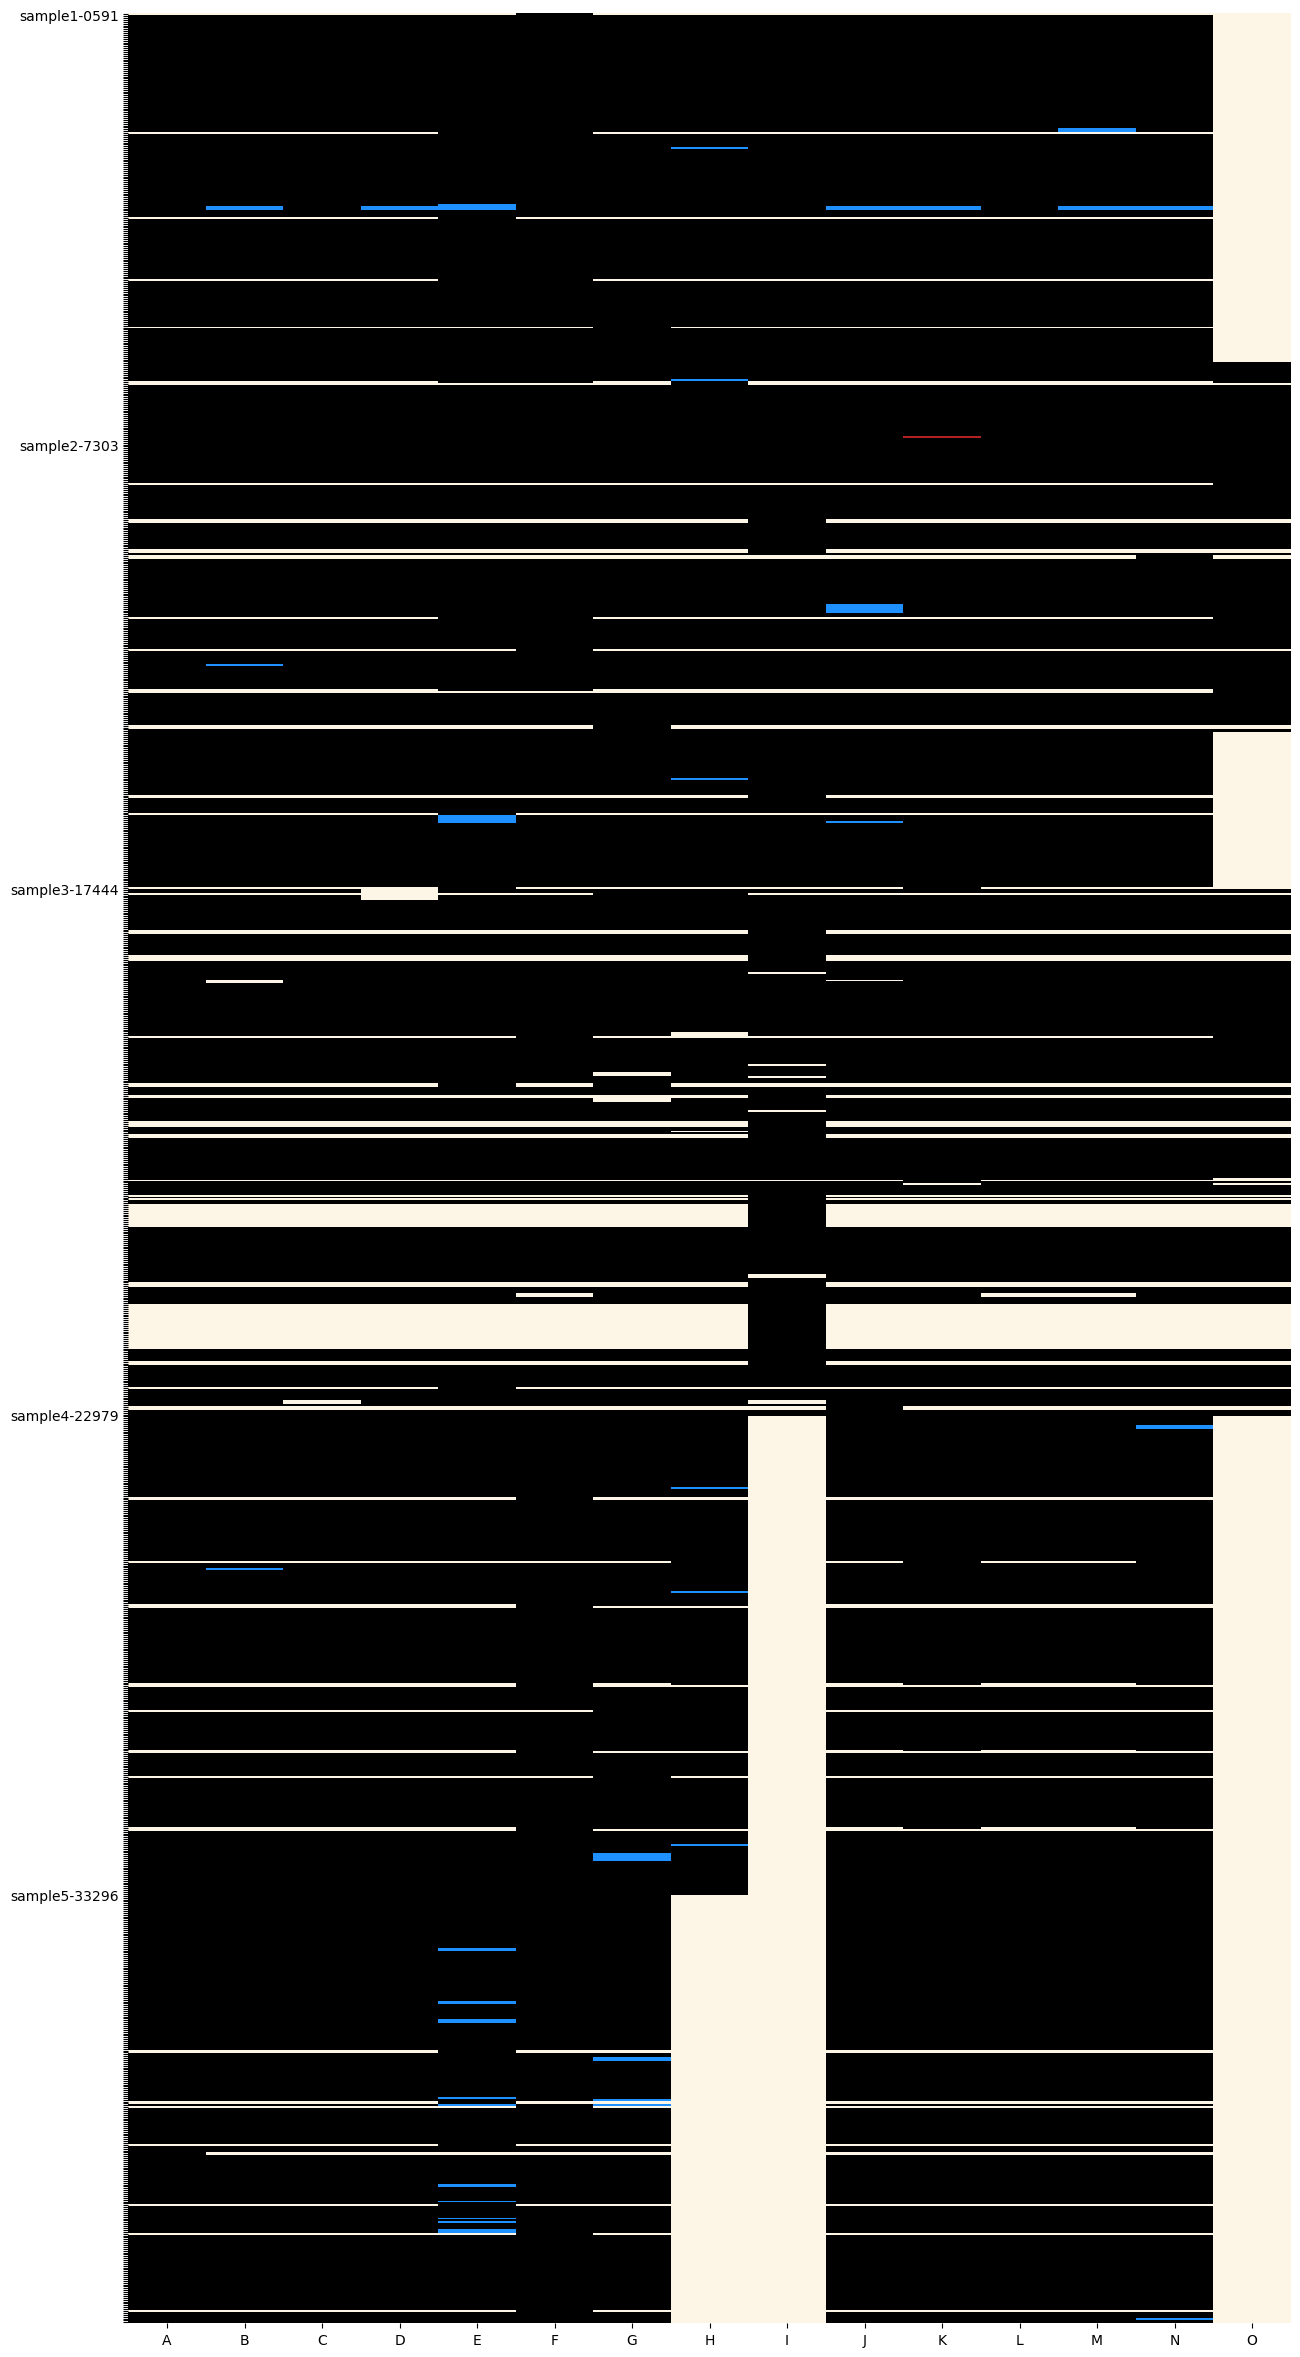

In [19]:
import seaborn as sb
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
#num_labels_to_display = 400  # Change this to the desired number

custom_ytick_labels = [l if i % (len(all_lines) // num_labels_to_display) == 0 else "" for i, l in enumerate(all_lines)]
cmap = ListedColormap(['black', 'firebrick', 'oldlace', 'dodgerblue'])

fig, ax = plt.subplots(figsize=(15, 30))
specific_keys_to_display = ['sample1-0591', 'sample2-7303', 'sample3-17444', 'sample4-22979', 'sample5-33296']
custom_ytick_labels = [l if l in specific_keys_to_display else "" for l in all_lines]
heatmap = sb.heatmap(grid, xticklabels=ms_names, yticklabels=custom_ytick_labels, ax=ax, cbar=False, cmap=cmap)
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0)
#print(grid.shape)
#plt.imshow(grid)

plt.savefig('../data/viz/pixelplot.png', dpi=300)

### Pixelplot - manuscripts from most complete to least complete 

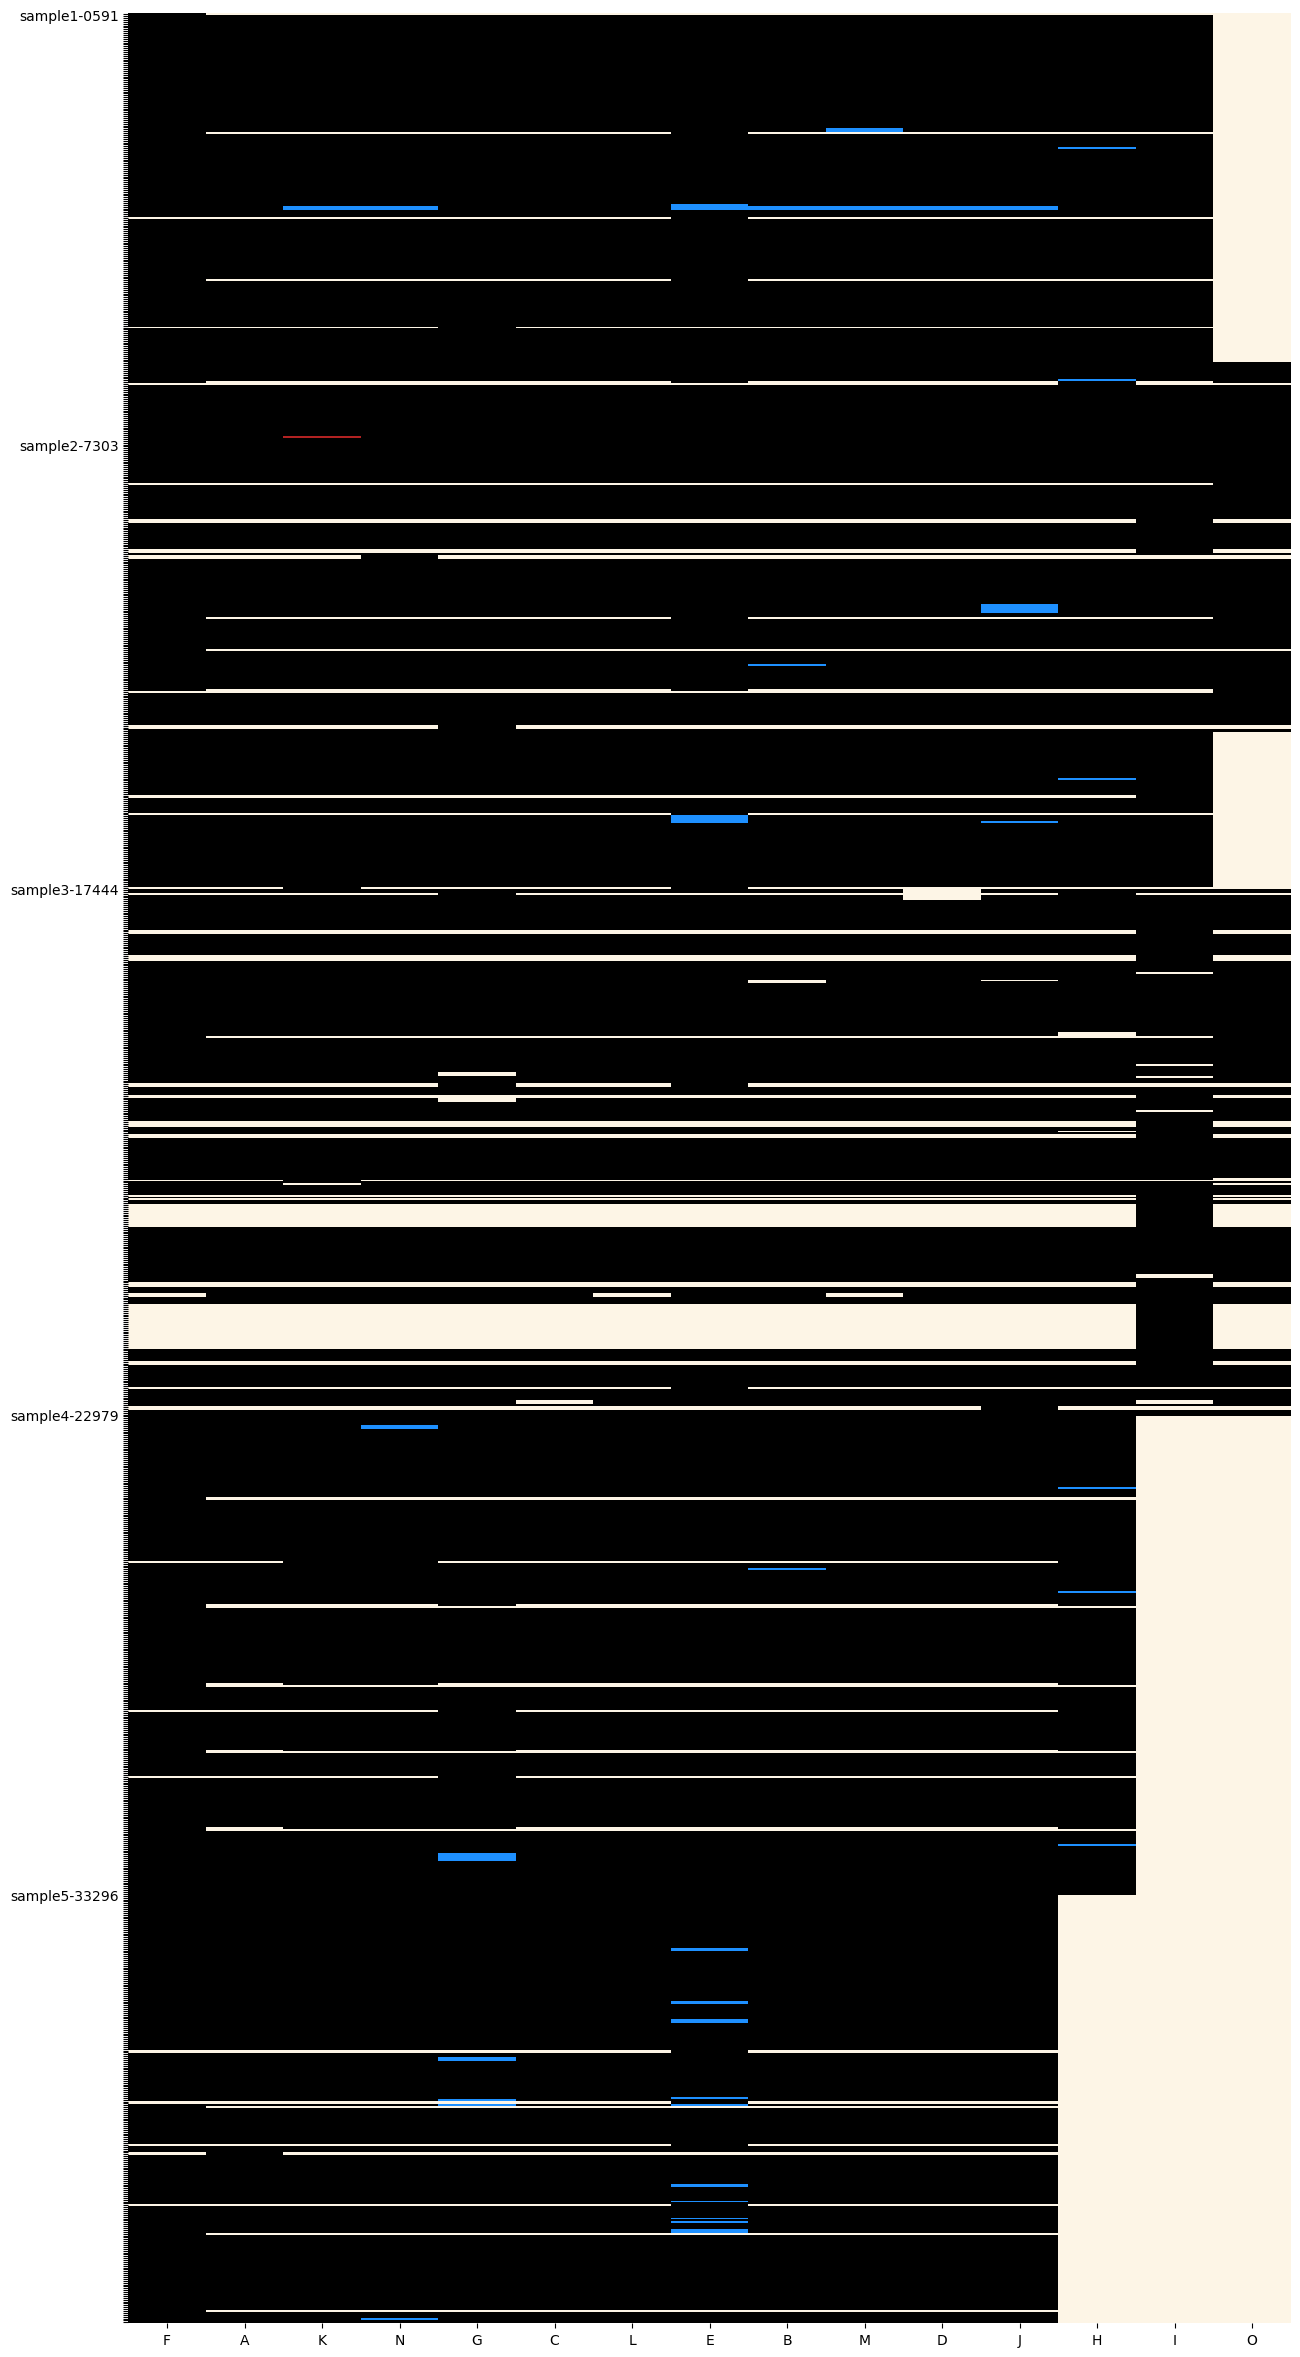

In [21]:
manuscript_line_counts = {}  # Create a dictionary to store manuscript line counts
for ms in mss:
    line_count = sum(1 for line_key in mss[ms] if mss[ms][line_key] not in ['<GAP>', '<NOTE>'])
    manuscript_line_counts[ms] = line_count

# Sort manuscripts by the number of lines (from most lines to fewer lines)
sorted_mss = sorted(manuscript_line_counts.keys(), key=lambda ms: manuscript_line_counts[ms], reverse=True)

# Rest of your code
all_lines = set()

for ms in sorted_mss:
    all_lines.update(mss[ms].keys())

def repl(n): 
    parts = n.split('_')  # Split the key by underscores
    if len(parts) >= 2:
        n = parts[0] + '-' + parts[-1]  # Concatenate the first and last parts with a hyphen
      #  print(n)
    else:
        n = n
    return n

all_lines = [repl(l) for l in all_lines]
all_lines = sorted(all_lines)
ms_names = sorted_mss  # Use the sorted manuscripts

grid = np.ones((len(all_lines), len(sorted_mss)))

for ms in sorted_mss:
    for line_key in mss[ms]:
        line = mss[ms][line_key]
        if line == '<GAP>':
            grid[all_lines.index(repl(line_key)), sorted_mss.index(ms)] = 0.5
        elif line == '<NOTE>':
            grid[all_lines.index(repl(line_key)), sorted_mss.index(ms)] = 2
        else:
            grid[all_lines.index(repl(line_key)), sorted_mss.index(ms)] = 0

import seaborn as sb
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
num_labels_to_display = 10  # Change this to the desired number

custom_ytick_labels = [l if i % (len(all_lines) // num_labels_to_display) == 0 else "" for i, l in enumerate(all_lines)]
cmap = ListedColormap(['black', 'firebrick', 'oldlace', 'dodgerblue'])

fig, ax = plt.subplots(figsize=(15, 30))
specific_keys_to_display = ['sample1-0591', 'sample2-7303', 'sample3-17444', 'sample4-22979', 'sample5-33296']
custom_ytick_labels = [l if l in specific_keys_to_display else "" for l in all_lines]

heatmap = sb.heatmap(grid, xticklabels=ms_names, yticklabels=custom_ytick_labels, ax=ax, cbar=False, cmap=cmap)
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0)
#print(grid.shape)
#plt.imshow(grid)

plt.savefig('../data/viz/pixelplot_fromlongtoshort.png')

## 2. Timeline Manuscripts

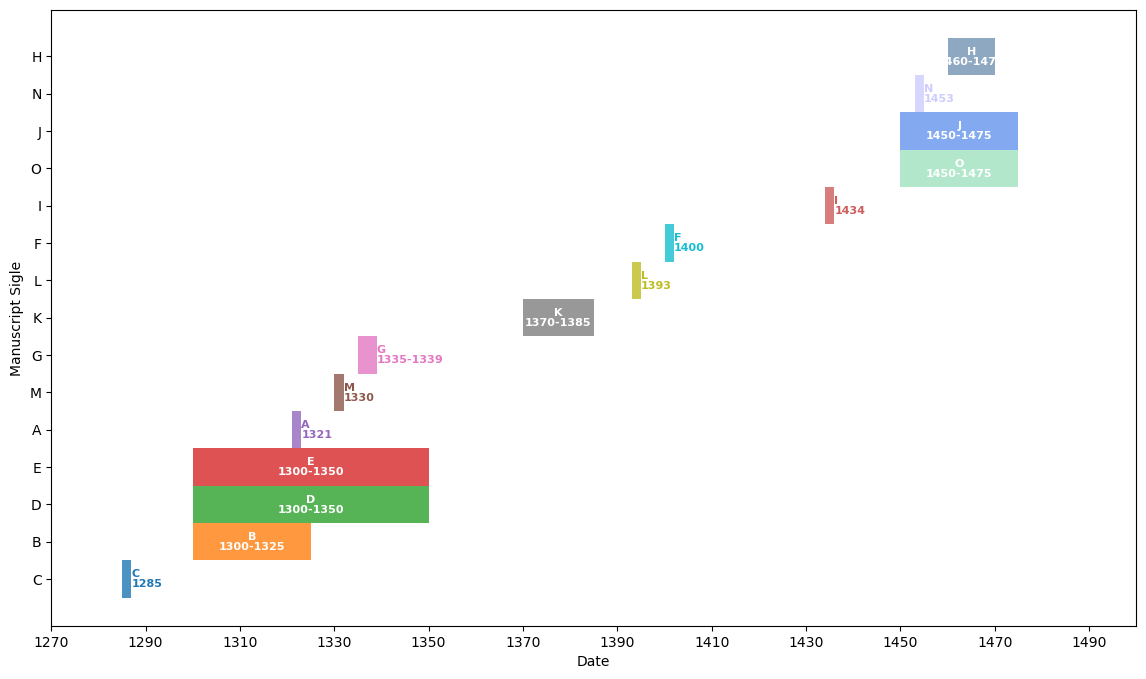

In [1]:
import matplotlib.pyplot as plt

# Define the dates and corresponding codes with their respective time ranges
data = [("C", 1285, 1285),
        ("B", 1300, 1325),
        ("D", 1300, 1350),
        ("E", 1300, 1350),
        ("A", 1321, 1321),
        ("M", 1330, 1330),
        ("G", 1335, 1339),
        ("K", 1370, 1385),
        ("L", 1393, 1393),
        ("F", 1400, 1400),
        ("I", 1434, 1434),
        ("O", 1450, 1475),
        ("J", 1450, 1475),
        ("N", 1453, 1453),
        ("H", 1460, 1470)]

colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd",
          "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf",
          "#CD5C5C", "#9FE2BF", "#6495ED", "#CCCCFF", "#7393B3",
          "#CD7F32", "#e7223c"]

# Create a horizontal bar chart with variable width bars
fig, ax = plt.subplots(figsize=(14, 8))
for i, (label, start, end) in enumerate(data):
    if end - start < 2: 
        width = 2
    else: 
        width = end - start
   # width = max(end - start, 12)
    left = start if width > 1 else start - 0.5
    text = str(start) if start == end else "{}-{}".format(start, end)
    
    ax.barh(label, width, height=1, left=left, align="center", color=colors[i].format(i), alpha=0.8)
    if width < 5:
        ax.text(left + width, i, text, ha="left", va="top", color=colors[i], fontsize=8, weight='bold')
        ax.text(left + width, i, label, ha="left", va="bottom", color=colors[i], fontsize=8, weight='bold')

    else:
        ax.text(left + width / 2, i, text, ha="center", va="top", color="white", fontsize=8, weight='bold')
        ax.text(left + width / 2, i, label, ha="center", va="bottom", color="white", fontsize=8, weight='bold')
   
    #ax.text(left + width / 2, i, text, ha="center", va="top", color="white", fontsize=7, weight='bold')
    #ax.text(left + width / 2, i, label, ha="center", va="bottom", color="white", fontsize=7, weight='bold')
   

# Set the limits and axis labels
ax.set_xlim(1270, 1500)
ax.set_xticks(range(1270, 1500, 20)) 
ax.set_xticklabels(range(1270, 1500, 20))
ax.set_xlabel("Date")
ax.set_ylabel("Manuscript Sigle")
fig.savefig("../data/viz/mytimeline.png", dpi=300)
# Show the plot
plt.show() 